### Marine Acoustics Workbook

In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

# Figures appear in notebook inline
%matplotlib inline


### Read .wav audio

In [2]:
# File path to .wav file
audio_file_path = "../data/humpback.wav"
filename = audio_file_path.split('/')[-1]

# Read entire mono .wav file using default sampling rate
y, sr = librosa.load(audio_file_path, sr=None, mono=True, offset=0.0, duration=None)
print(f'Loaded file: {filename}\n--------------------------------\n\
Duration: {y.size/sr} seconds\n--------------------------------\n\
Sample rate: {sr} Hz\n--------------------------------\n')



Loaded file: humpback.wav
--------------------------------
Duration: 255.65 seconds
--------------------------------
Sample rate: 4000 Hz
--------------------------------



### Define constants (frame_length, hop_length)

In [19]:
# CONSTANTS
frame_length = 100    # window size in samples
hop_length = frame_length//2    # stride length between windows in samples
n_mels = 64    # no. of mel-bands used to partition linear frequencies
n_mfcc = 12    # no. of mfccs to calculate

print(f'Frame duration: {1000*frame_length/sr} ms\nOverlap: {100*hop_length/frame_length}%')


Frame duration: 25.0 ms
Overlap: 50.0%


### Functions

In [20]:
def slice_data(data, frame_length, hop_length):
    """Slice 1D array into frames with a given overlap"""
    frame_view = librosa.util.frame(data, frame_length=frame_length, hop_length=hop_length, axis=0)
    
    return frame_view


def plot_waveform(y, sr, axis='s', offset=0.0, title='Audio Waveform', xlabel='Time (s)', ylabel='Amplitude'):
    """Plot the signal waveform in the time domain"""

    # Plot
    plt.figure()
    librosa.display.waveshow(y, sr=sr, max_points=sr//2, axis=axis, offset=offset)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def plot_spectrogram(y, sr, n_fft=frame_length, hop_length=hop_length, title='Linear-frequency Power Spectrogram', xlabel='Time (s)', ylabel='Frequency (Hz)'):
    """Plot the linear-frequency power spectrogram"""

    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window='hann')  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)    # STFT in dB
    
    # Plot
    plt.figure()
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='s', y_axis='linear')
    plt.colorbar(format="%+2.f dB")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def plot_mel_spectrogram(y, sr, n_fft=frame_length, hop_length=hop_length, n_mels=n_mels, title='Mel-frequency Power Spectrogram', xlabel='Time (s)', ylabel='Frequency (Hz)'):
    """Plot the mel-frequency power spectrogram"""

    D = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=frame_length, hop_length=hop_length, n_mels=n_mels)  # mel-power spectrogram of y
    S_db = librosa.power_to_db(D, ref=np.max)    # mel-power spectrogram in dB
    
    # Plot
    plt.figure()
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='s', y_axis='linear')
    plt.colorbar(format="%+2.f dB")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)



### Slice signal into frames

In [21]:
# Create view of sliced signal
y_frames = slice_data(y, frame_length, hop_length)
print(f'Sliced signal into {y_frames.shape[0]} frames with {100*hop_length/frame_length}% overlap and duration {1000*frame_length/sr} ms.')


Sliced signal into 20451 frames with 50.0% overlap and duration 25.0 ms.


### Plot the audio waveform

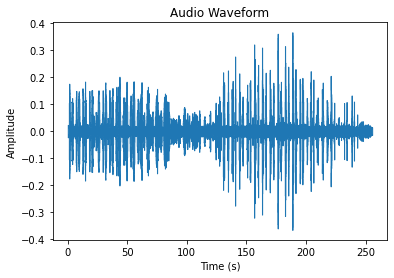

In [22]:
plot_waveform(y, sr)


### Plot a linear-frequency power spectrogram

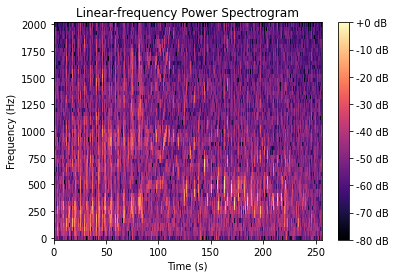

In [23]:
plot_spectrogram(y, sr)


### Plot a mel-frequency power spectrogram

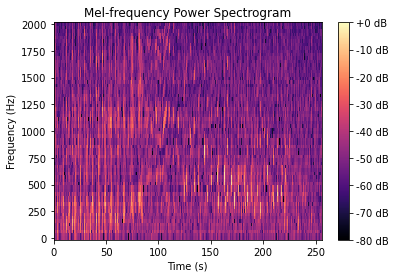

In [24]:
plot_mel_spectrogram(y, sr)


### Calculate MFCCs, Deltas, and Delta-Deltas

In [37]:
# Calculate MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=frame_length, hop_length=hop_length, n_mels=n_mels)
print(f'First {n_mfcc} MFCCs: {mfccs[:,0]}')

first_mfcc = librosa.feature.mfcc(y=y_frames[0], sr=sr, n_mfcc=n_mfcc, n_fft=frame_length, hop_length=hop_length, n_mels=n_mels)
print(first_mfcc[:,0])

# Calculate the delta of the mfccs



# Calculate the delta-delta of the mfccs


First 12 MFCCs: [-409.7646       8.581801    15.900955    23.931812     1.0240664
    8.487936    -9.2066555   -5.6914115    7.048259    -0.8699417
    2.377391   -11.291279 ]
[-409.7646       8.581801    15.900956    23.931814     1.0240666
    8.487936    -9.2066555   -5.691411     7.048259    -0.8699417
    2.377391   -11.291279 ]
